In [20]:
import numpy as np
import operator
import logging
import time

import optuna

import jax.numpy as jnp
from jax import grad, jit

from functools import partial
import gwjax
import gwjax.imrphenom

from pycbc.catalog import Merger
from pycbc.filter import resample_to_delta_t, highpass
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc.waveform import get_fd_waveform
from pycbc.filter import matched_filter, sigmasq, get_cutoff_indices

from ripple.waveforms import IMRPhenomD
from ripple.waveforms.IMRPhenomD import gen_IMRPhenomD_polar
from ripple import ms_to_Mc_eta

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 20})
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

from optuna.visualization import plot_contour

In [21]:
class NeedsInvestigatingCallback(object):
    """A callback for Optuna which identifies potential events."""

    def __init__(self, early_stopping_rounds: int, snr_threshold: int, direction: str = "minimize") -> None:
        self.snr_threshold = snr_threshold
        self.early_stopping_rounds = early_stopping_rounds
        
        self._iter = 0

        if direction == "minimize":
            self._operator = operator.lt
            self._score = np.inf
        elif direction == "maximize":
            self._operator = operator.gt
            self._score = -np.inf
        else:
            ValueError(f"invalid direction: {direction}")

    def __call__(self, study: optuna.Study, trial: optuna.Trial) -> None:
        """Goes onto Stocastic Gradient Descent."""
        if self._operator(study.best_value, self._score):
            self._iter = 0
            self._score = study.best_value
        else:
            self._iter += 1

        if self._score <= self.snr_threshold:
            if self._iter >= self.early_stopping_rounds:
                study.stop()
                print(study.best_params)
                
        if self._score >= self.snr_threshold:
            study.stop()
            print(f'Optuna has stopped with {study.best_params} because snr threshold has been reached.')

In [26]:
# Define the conditiion data function
dynfac = 1.0e23
def condition(strain, sampling_rate):
    tmp = resample_to_delta_t(highpass(strain, 15.0), 1.0/sampling_rate).crop(2,2)
    return (dynfac*tmp)

# Define the PSD function 
def estimate_psd(strain, delta_f):
    psd = strain.psd(4)
    psd = interpolate(psd, delta_f)
    psd = inverse_spectrum_truncation(psd, int(4 * strain.sample_rate),
                                  low_frequency_cutoff=15, trunc_method='hann')
    return psd

# Define the matched filter function
def matched_filter(signal_duration, sampling_rate, kmin, kmax, fcore, template): 
    workspace = jnp.zeros(int(sampling_rate*signal_duration), dtype=complex) 
    result_fft = fcore * jnp.conjugate(template) 
    workspace = workspace.at[kmin:kmax].set(result_fft)
    result = jnp.fft.ifft(workspace)
    result *= len(result)
    return result

# Define the waveform template function
def waveform_template(freqs, low_freq, m1, m2, s1, s2):
    m1_msun = m1 # In solar masses
    m2_msun = m2
    chi1 = 0.0
    chi2 = 0.0
    tc = 1.0 # Time of coalescence in seconds
    phic = 1.3
    dist_mpc = 440 # Distance to source in Mpc
    inclination = 0.0 # Inclination Angle
    polarization_angle = 0 # Polarization angle
    f_ref = low_freq

    Mc, eta = ms_to_Mc_eta(jnp.array([m1_msun, m2_msun]))
    params = jnp.array([Mc, eta, chi1, chi2, dist_mpc, tc, phic, inclination, polarization_angle])
    return gen_IMRPhenomD_polar(freqs, params, f_ref)

# Define sigma squared function 
def sigma_squared(delta_freq, invpsd, template):
    weighted_inner = jnp.sum(template*jnp.conj(template)*invpsd)
    h_norm = 4*delta_freq
    sigma_squared = jnp.real(weighted_inner)*h_norm
    #print(f'sigma_squared {sigma_squared}')
    return sigma_squared

# Define the waveform template function
def optuna_waveform_template(freqs, low_freq, chi1, chi2, tc, phic, dist_mpc, inclination, polarization_angle,  m1, m2):
    Mc, eta = ms_to_Mc_eta(jnp.array([ m1, m2]))
    params = jnp.array([Mc, eta , chi1, chi2, dist_mpc, tc, phic, inclination, polarization_angle])
    return gen_IMRPhenomD_polar(freqs, params, low_freq)


def snr(invpsd, delta_freq, sampling_rate, matched_output, sigma_squared_output):
    norm = 4*delta_freq / jnp.sqrt(sigma_squared_output)
    snr = matched_output*norm
    snr_min = int((2+4)*sampling_rate)
    snr_max = len(snr)-int((2)*sampling_rate)
    snr = snr[snr_min:snr_max]
    peak = jnp.argmax(jnp.absolute(snr))
    snrp = jnp.absolute(snr[peak])
    return(snrp)


# Define the objective function to minimize (negative SNR)
def objective(params):
    m1, m2, s1, s2 = params
    template, _ = my_waveform_template(m1, m2, s1, s2)
    #print(template)
    matched_output = my_matched_filter(template)
    #print(matched_output)
    sigma_squared_output = my_sigma_squared(template)
    #print(sigma_squared_output)
    snr_peak = my_snr(matched_output, sigma_squared_output)
    #print(snr_peak)
    return -snr_peak

In [27]:
# Get the data and estimate the PSDs
merger = Merger("GW150914")
sampling_rate = 2048 # Sampling rate in Hz
data = condition(merger.strain('H1'), sampling_rate)
signal_duration = float(data.duration)  # Duration of the signal in seconds
delta_freq = data.delta_f

invpsd = estimate_psd(data, data.delta_f)**(-1)

fcore = data.to_frequencyseries()*invpsd

#Get the frequency range
nyquist = sampling_rate//2
freqs = jnp.arange(1+(nyquist*signal_duration))/signal_duration


#Determine the low freq and high frequency cut off
low_freq_cut_off = 15
high_frq_cut_off = 900
kmin, kmax = int(low_freq_cut_off*signal_duration), int(high_frq_cut_off*signal_duration)

#Make everything the same length
fcore = jnp.asarray(fcore[kmin:kmax])
freqs = freqs[kmin:kmax]
invpsd = jnp.asarray(invpsd[kmin:kmax]) # can't take fft because it needs to start at 0 to nyquist 

#Get the stage ready for the template
chi1 = 0.0
chi2 = 0.0
tc = 1.0 # Time of coalescence in seconds
phic = 1.3
dist_mpc = 440 # Distance to source in Mpc
inclination = 0.0 # Inclination Angle
polarization_angle = 0 # Polarization angle
my_waveform_template = partial(waveform_template, freqs, low_freq_cut_off)
my_optuna_waveform_template = partial(optuna_waveform_template, freqs, low_freq_cut_off, chi1, chi2, tc, phic, dist_mpc, inclination, polarization_angle)
my_matched_filter = partial(matched_filter, signal_duration, sampling_rate, kmin, kmax, fcore)
my_sigma_squared = partial(sigma_squared, delta_freq, invpsd)
my_snr = partial(snr, invpsd, delta_freq, sampling_rate)

In [28]:
def optuna_objective(trial):
    m1 = trial.suggest_float('m1', 2, 100, step=0.000001)
    m2 = trial.suggest_float('m2', 2, 100, step=0.000001)
    template, _ = my_optuna_waveform_template(m1, m2)
    matched_output = my_matched_filter(template)
    sigma_squared_output = my_sigma_squared(template)
    snr_peak = my_snr(matched_output, sigma_squared_output)
    return snr_peak

In [29]:
optuna.logging.disable_default_handler()
direction="maximize"
study = optuna.create_study(sampler=optuna.samplers.TPESampler(), direction=direction)
needs_to_be_investigated = NeedsInvestigatingCallback(50, snr_threshold=200, direction=direction)
start_time = time.time()
study.optimize(optuna_objective, callbacks=[needs_to_be_investigated], n_trials=100)
print("Time taken", time.time() - start_time)
print(f'GW150419 has the best {study.best_params} with a snr {study.best_value}')

{'m1': 37.420013, 'm2': 37.331417}
Time taken 21.318464517593384
GW150419 has the best {'m1': 37.420013, 'm2': 37.331417} with a snr 19.600360198610616


/tmp/ipykernel_16709/3571258878.py:1: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_contour(study, target_name="SNR")
Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


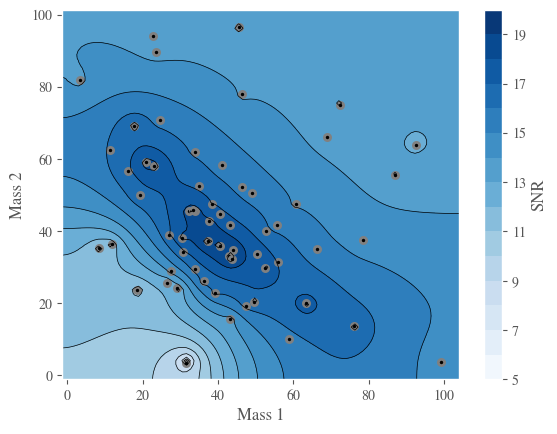

In [30]:
fig = optuna.visualization.matplotlib.plot_contour(study, target_name="SNR")
fig.set_title("")
fig.set_xlabel("Mass 1")
fig.set_ylabel("Mass 2")
fig.figure.savefig('gwtuna_contour_plot2.png', dpi=300, bbox_inches='tight')

/tmp/ipykernel_16709/4230620112.py:1: ExperimentalWarning: plot_edf is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_edf(study)


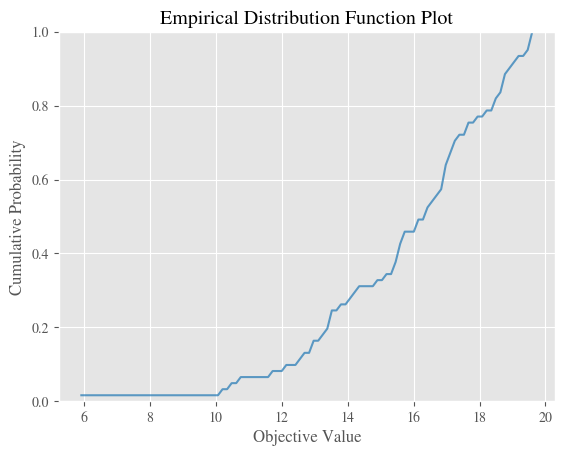

In [31]:
fig = optuna.visualization.matplotlib.plot_edf(study)

/tmp/ipykernel_16709/1964054597.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_optimization_history(study, target_name="SNR")


Text(0.5, 1.0, '')

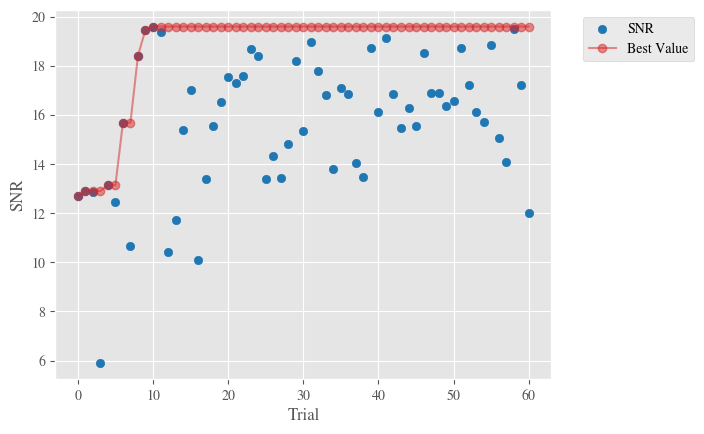

In [32]:
fig = optuna.visualization.matplotlib.plot_optimization_history(study, target_name="SNR")
fig.set_title("")